# Aangiften van fietsdiefstallen in Groningen

Op basis van het bestand `Diefstal fiets Groningen stad vanaf 2013.xlsx` ([bron](https://github.com/KennisnetwerkDataScience/Fietsendiefstallen)) geëxporteerd naar `aangiften.csv`.

## Read and prepare the data

In [2]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# configure matplotlib
%matplotlib inline
matplotlib.rc('figure', figsize=(15,6))


# read file, parse dates
aangiften = pd.read_csv('aangiften.csv', 
                        parse_dates=['Begin-pleegdatum/tijd', 'Eind-pleegdatum/tijd'],
                        date_parser=lambda x: pd.datetime.strptime(x, '%d-%m-%Y %H:%M:%S'))
# select relevant columns
aangiften = aangiften[['Pleegpostcode', 'Begin-pleegdatum/tijd', 'Eind-pleegdatum/tijd', 'Temperatuur', 'Weer', 'X', 'X']]
# rename columns to simplify typing
aangiften.columns = ['postcode', 'begin', 'eind', 'temperatuur', 'weer', 'x', 'y']
# ignore when aangifte time is longer than a week
aangiften['duur'] = (aangiften.eind - aangiften.begin).astype('timedelta64[h]')
aangiften = aangiften[aangiften.duur < (7*24)]
aangiften.head()

,postcode,begin,eind,temperatuur,weer,x,y,duur
0,9715PZ,2017-09-20 17:30:00,2017-09-21 06:00:00,NaN,Geen data aanwezig,234234,234234,12.0
1,9713RD,2017-09-20 14:00:00,2017-09-20 15:00:00,NaN,Geen data aanwezig,235012,235012,1.0
2,9716EA,2017-09-20 08:15:00,2017-09-20 11:30:00,NaN,Geen data aanwezig,233211,233211,3.0
3,9714EL,2017-09-19 17:30:00,2017-09-20 16:15:00,NaN,Geen data aanwezig,234073,234073,22.0
4,9713AW,2017-09-19 12:30:00,2017-09-19 15:30:00,NaN,Geen data aanwezig,234013,234013,3.0


Allereerst een paar algemene statistieken:

In [3]:
aangiften.describe()

,temperatuur,x,y,duur
count,15545.000000,15581.000000,15581.000000,15581.000000
mean,10.887687,233698.397150,233698.397150,12.761055
std,6.640465,1066.336236,1066.336236,22.178175
min,-11.900000,229158.000000,229158.000000,0.000000
25%,6.200000,233185.000000,233185.000000,1.000000
50%,10.900000,233729.000000,233729.000000,5.000000
75%,15.700000,234210.000000,234210.000000,13.000000
max,33.800000,239538.000000,239538.000000,167.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024652886B00>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000024652AF55C0>]], dtype=object)

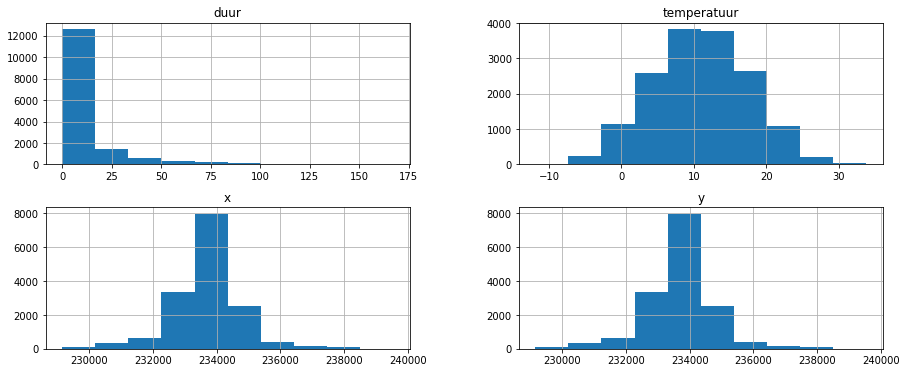

In [4]:
aangiften.hist()

Hieruit zien we meteen dat de meeste aangegeven diefstallen binnen een periode van 24 uur zijn gepleegd.

Daarnaast zien we dat de temperatuur een normale verdeling heeft, wat waarschijnlijk meer zegt over het weer dan over de diefstallen.

## De postcodes met de meeste aangiften

Eerst tellen we de diefstallen per postcode, waarbij we achtereenvolgens naar de eerste 4 en de eerste 5 tekens van de postcode kijken.

In [151]:
aangiften['postcode4'] = aangiften.postcode.str[:4]
aangiften.postcode4.value_counts().head(10)

9712    1501
9711    1495
9713     979
9726     789
9718     652
9715     627
9741     558
9714     541
9717     463
9721     349
Name: postcode4, dtype: int64

Zoals verwacht staan 9711-9713 (binnenstad) met stip bovenaan. Schilders- en zeeheldenwijk (9718, 9726) en Korrewegwijk (9714, 9715) vormen de subtop

In [138]:
aangiften['postcode5'] = aangiften.postcode.str[:5]
aangiften.postcode5.value_counts().head(10)

9726A    566
9712H    330
9713G    314
9711H    265
9741C    201
9711L    185
9712J    182
9711K    155
9712B    142
9718A    134
Name: postcode5, dtype: int64

Ook als we op 5 tekens van de postcode gaan kijken, wordt de lijst gedomineerd door de binnenstad. Opvallend is wel dat de Zeeheldenbuurt (9726A, net buiten de binnenstad) met kop en schouders bovenaan staat. Binnen deze postcode zien we:

In [139]:
aangiften[aangiften.postcode.str.contains('9726A') == True].postcode.value_counts().head(10)

9726AE    532
9726AC     14
9726AR      8
9726AP      3
9726AM      2
9726AS      2
9726AD      2
9726AA      2
9726AJ      1
Name: postcode, dtype: int64

En dan zijn we aanbeland bij het Stationsplein en de Stationsweg.

## Door het jaar heen

Voor spreiding door het jaar heen, moeten we eerst besluiten hoe we omgaan met de aangifte tijd, die niet een tijdstip maar een periode is. Ik kies er voor om het gemiddelde van de tijden te nemen.

In [140]:
aangiften['tijdstip'] = aangiften.begin + (aangiften.eind - aangiften.begin)/2
aangiften[['begin', 'eind', 'tijdstip']].head(10)


,begin,eind,tijdstip
0,2017-09-20 17:30:00,2017-09-21 06:00:00,2017-09-20 23:45:00
1,2017-09-20 14:00:00,2017-09-20 15:00:00,2017-09-20 14:30:00
2,2017-09-20 08:15:00,2017-09-20 11:30:00,2017-09-20 09:52:30
3,2017-09-19 17:30:00,2017-09-20 16:15:00,2017-09-20 04:52:30
4,2017-09-19 12:30:00,2017-09-19 15:30:00,2017-09-19 14:00:00
5,2017-09-19 12:00:00,2017-09-19 23:00:00,2017-09-19 17:30:00
6,2017-09-19 08:30:00,2017-09-19 09:00:00,2017-09-19 08:45:00
7,2017-09-19 08:30:00,2017-09-19 16:00:00,2017-09-19 12:15:00
8,2017-09-18 19:30:00,2017-09-19 00:15:00,2017-09-18 21:52:30
9,2017-09-17 21:58:00,2017-09-17 21:58:00,2017-09-17 21:58:00


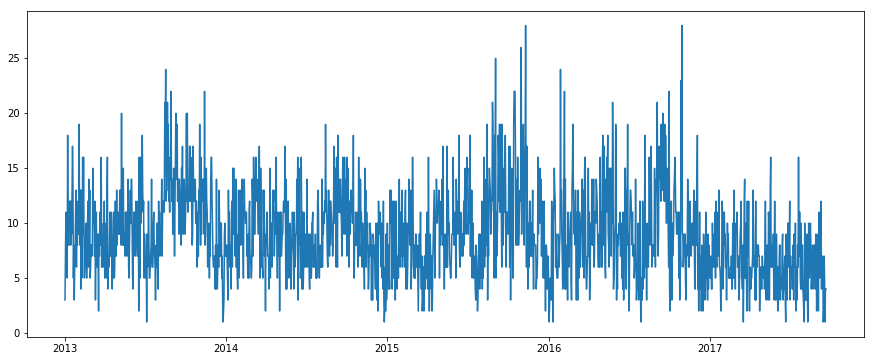

In [141]:
aangiften['datum'] = aangiften.tijdstip.dt.date
aangiften.datum.value_counts().plot()

De figuur suggereert jaarlijkse pieken in het najaar. Om hier beter zicht op te krijgen, kijken we vervolgens naar de aangiften per weeknummer:

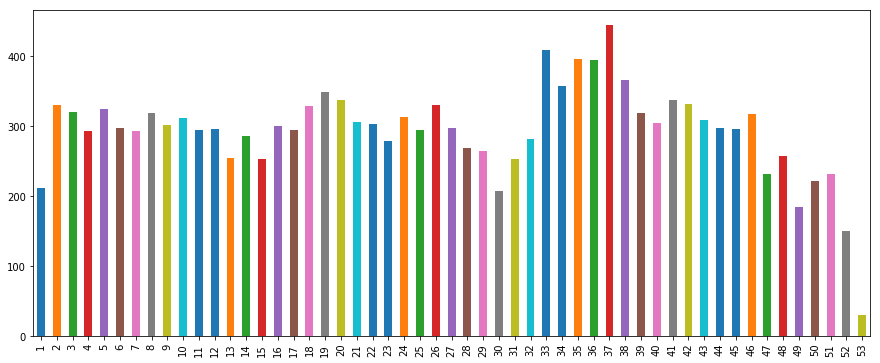

In [142]:
aangiften['week'] = aangiften.tijdstip.dt.week
aangiften.week.value_counts().sort_index().plot(kind='bar')

Bij tellingen op weeknummer zien we een lichte piek rond augustus/september en een serieus dal rond de kerstvakantie.

## Per dag
Om de aangiften per uur van de dag te verdelen, maken we gebruik van het tijdstip dat het gemiddelde is van de begin- en de eindtijd. De aanname is dat dit bij grote aantallen verantwoord is.

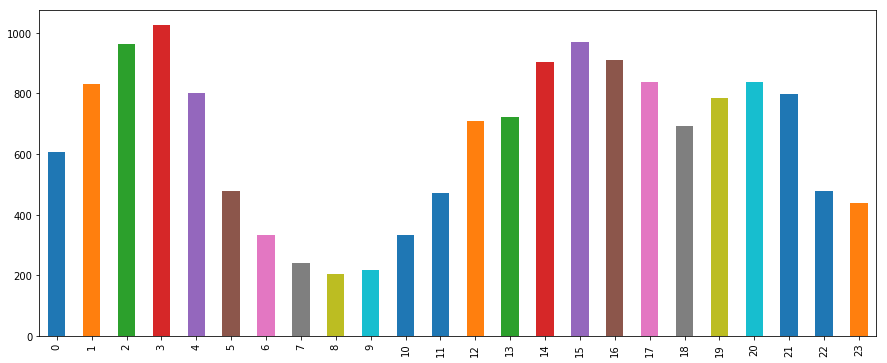

In [150]:
aangiften.tijdstip.dt.hour.value_counts().sort_index().plot(kind='bar')


Wat opvalt zijn de dalen rond middernacht en in de ochtendspits. De piek in de nacht (rond 3 uur) kan goed het gevolg zijn van het middelen van begin- en eindtijd ("fiets gestolen tussen 22 en 8 uur").

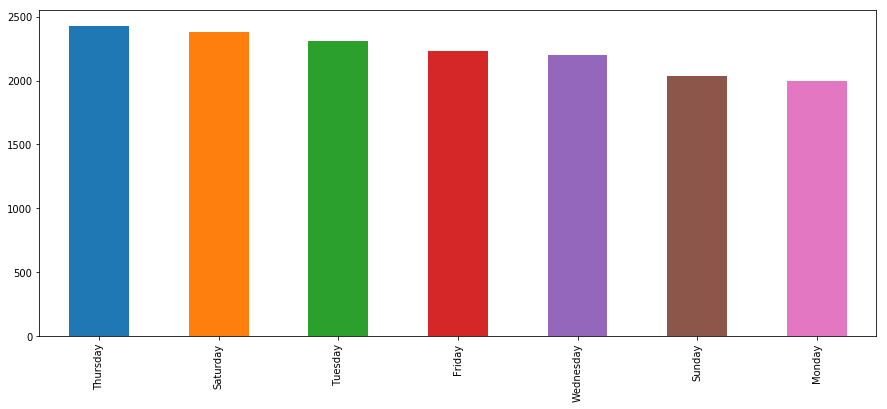

In [166]:
aangiften['dag'] = aangiften.tijdstip.dt.weekday_name
aangiften.dag.value_counts().plot(kind='bar')

Donderdag en zaterdag komen het meest voor, waarschijnlijk omdat dit de uitgaansdagen zijn. Maar de verschillen zijn nauwelijks significant.

## Het weer
Het weer zegt ons helaas weinig, omdat alleen 'negatieve' weersomtandigheden worden vermeld ('Zonnnig' en 'Strakblauwe lucht' komen niet voor).

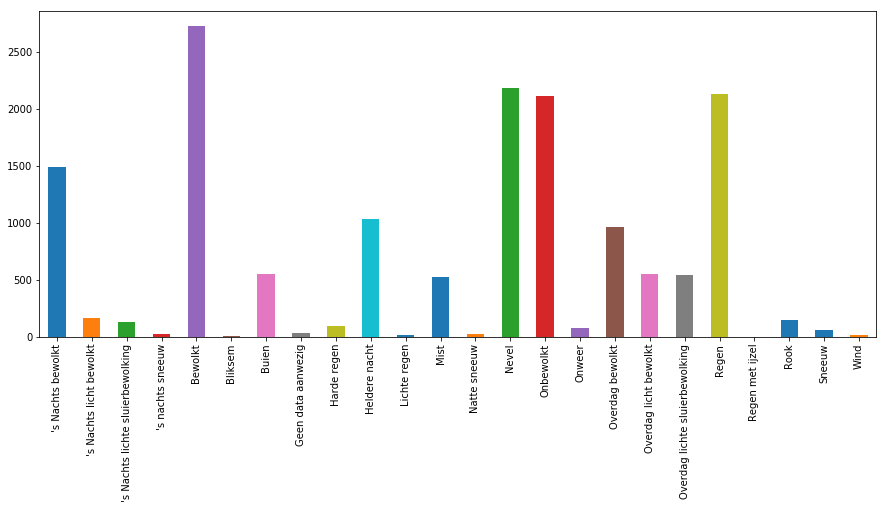

In [144]:
aangiften.weer.value_counts().sort_index().plot(kind='bar')

Om te tellen op basis van temperatuur, moeten we eerst de aangiften zonder temperatuur verwijderen. Vervolgens ronden we de temperatuur af op hele graden.

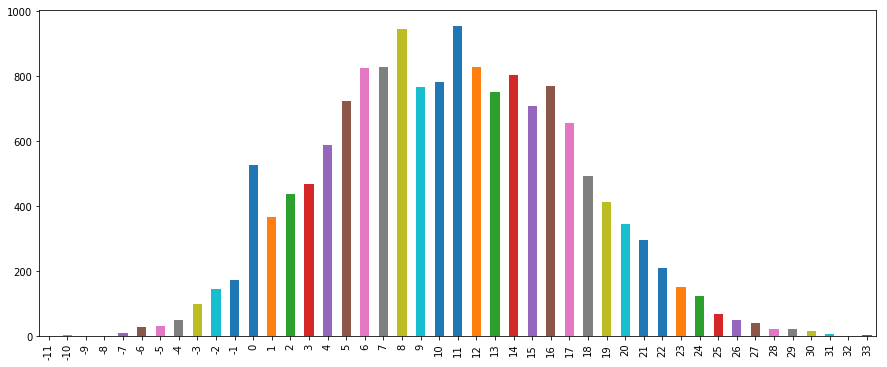

In [159]:
aangiften.dropna(subset=['temperatuur']).temperatuur.astype(int).value_counts().sort_index().plot(kind='bar')

## Verder...

In een volgend deel wil ik meer naar de relaties _tussen_ de attributen gaan kijken. Als eerste aanzet:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002465F27A6A0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000002466063B390>]], dtype=object)

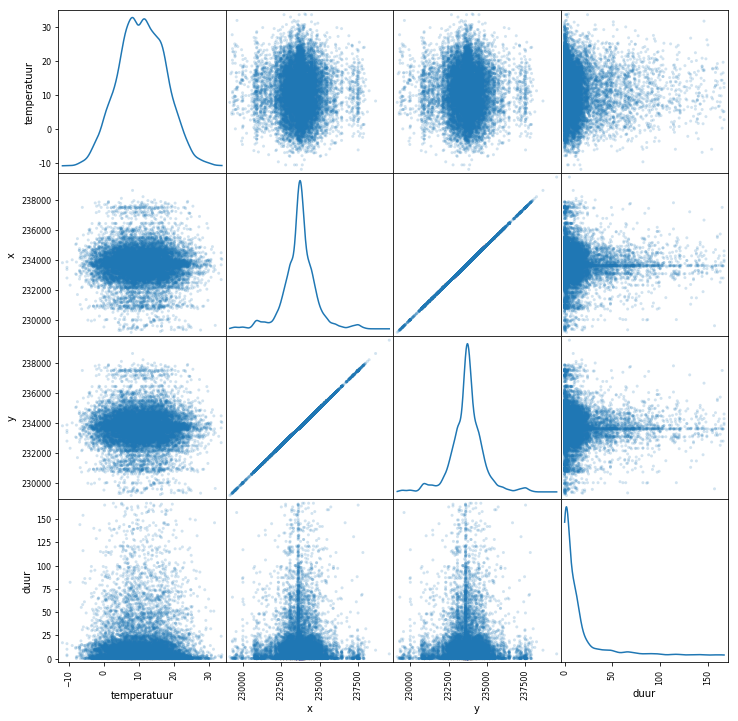

In [7]:
from pandas.plotting import scatter_matrix
scatter_matrix(aangiften, alpha=0.2, figsize=(12, 12), diagonal='kde')

Er is al genoeg te zien:

- we zien de normale verdeling van de temperatuur weer (links boven)
- evenals de overwegend korte periode waarin de diefstal heeft plaats gevonden (rechts onder)
- de x en de y laten duidelijke pieken zien, wat bevestigd dat de meeste aangiften een beperkt gebied betreffen
- de betekenis van de diagonale lijnen die je krijgt als je de x en de y tegenover elkaar zet ontgaat me

Tenslotte: Schrijf de gebruikte gegevens naar CSV zodat we daar in een vervolg gebruik van kunnen maken.


In [145]:
aangiften.to_csv('aangiften_plus.csv')